# Predicting Health Insurance

---

## Importing Libraries

In [397]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

---

## Loading Data

In [398]:
df = pd.read_csv('../HealthInsurancePredictor/data/customer.csv')

df.head()

,Unnamed: 0,custid,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,code_column,gas_usage,rooms,recent_move_b
0,7,000006646_03,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,1047,210.0,3,F
1,8,000007827_01,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,1047,3.0,6,T
2,9,000008359_04,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,1047,40.0,3,F
3,10,000008529_01,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,1047,120.0,2,F
4,11,000008744_02,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,1047,3.0,2,F


---

## Data Exploration

In [399]:
# Display the shape of the DataFrame (number of rows and columns)
df.shape

(72458, 15)

In [400]:
# Display information about the DataFrame including data types and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72458 entries, 0 to 72457
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      72458 non-null  int64  
 1   custid          72458 non-null  object 
 2   sex             72458 non-null  object 
 3   is_employed     46943 non-null  object 
 4   income          72458 non-null  float64
 5   marital_status  72458 non-null  object 
 6   health_ins      72458 non-null  bool   
 7   housing_type    70772 non-null  object 
 8   num_vehicles    70772 non-null  float64
 9   age             72458 non-null  int64  
 10  state_of_res    72458 non-null  object 
 11  code_column     72458 non-null  int64  
 12  gas_usage       70772 non-null  float64
 13  rooms           72458 non-null  int64  
 14  recent_move_b   70771 non-null  object 
dtypes: bool(1), float64(3), int64(4), object(7)
memory usage: 7.8+ MB


In [401]:
# Display summary statistics of the DataFrame
df.describe()

,Unnamed: 0,income,num_vehicles,age,code_column,gas_usage,rooms
count,72458.000000,7.245800e+04,70772.000000,72458.000000,72458.000000,70772.000000,72458.000000
mean,49910.637556,4.188143e+04,2.066820,49.208893,3285.523572,41.230501,3.494549
std,28772.082702,5.827460e+04,1.170076,18.090035,2661.775225,63.149323,1.706537
min,7.000000,-6.900000e+03,0.000000,0.000000,131.000000,1.000000,1.000000
25%,24911.250000,1.070000e+04,1.000000,34.000000,1305.000000,3.000000,2.000000
50%,49838.000000,2.640000e+04,2.000000,48.000000,2269.000000,10.000000,3.000000
75%,74786.750000,5.200000e+04,3.000000,62.000000,4979.000000,60.000000,5.000000
max,100000.000000,1.257000e+06,6.000000,120.000000,8962.000000,570.000000,6.000000


In [402]:
# Print the number of null values for each column
print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
Unnamed: 0            0
custid                0
sex                   0
is_employed       25515
income                0
marital_status        0
health_ins            0
housing_type       1686
num_vehicles       1686
age                   0
state_of_res          0
code_column           0
gas_usage          1686
rooms                 0
recent_move_b      1687
dtype: int64


In [403]:
# Print the number of duplicate rows
print("\nDuplicate rows:")
print(df.duplicated().sum())


Duplicate rows:
0


In [404]:
# Print the number of unique values for each column
print("\nUnique values per column:")
print(df.nunique())


Unique values per column:
Unnamed: 0        72458
custid            72458
sex                   2
is_employed           2
income             4445
marital_status        4
health_ins            2
housing_type          4
num_vehicles          7
age                  81
state_of_res         51
code_column          49
gas_usage            57
rooms                 6
recent_move_b         2
dtype: int64


---

## Data Preprocessing

# Brief Analysis of the Columns

## Unnecessary Columns:

- `Unnamed: 0` - This column functions as an index, so it is irrelevant and can be removed.

- `custid` - The ID of each customer is also unnecessary for the analysis and will be removed as well.

- `code_column` - The column containing the code is likewise irrelevant.

## Necessary Columns:

- The columns: `sex`, `is_employed`, `income`, `marital_status`, **`health_ins`**, `housing_type`, `num_vehicles`, `age`, `state_of_res`, `gas_usage`, `rooms`, and `recent_move_b` are all relevant for predicting the primary variable **`health_ins`**.


### Drop unnecessary columns

In [405]:
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'custid', 'code_column'], errors='ignore')

df.head()

,sex,is_employed,income,marital_status,health_ins,housing_type,num_vehicles,age,state_of_res,gas_usage,rooms,recent_move_b
0,Male,True,22000.0,Never married,True,Homeowner free and clear,0.0,24,Alabama,210.0,3,F
1,Female,NaN,23200.0,Divorced/Separated,True,Rented,0.0,82,Alabama,3.0,6,T
2,Female,True,21000.0,Never married,True,Homeowner with mortgage/loan,2.0,31,Alabama,40.0,3,F
3,Female,NaN,37770.0,Widowed,True,Homeowner free and clear,1.0,93,Alabama,120.0,2,F
4,Male,True,39000.0,Divorced/Separated,True,Rented,2.0,67,Alabama,3.0,2,F


### Handling missing values

#### Handling missing values in is_employed column

These will be the NaN values that will require more attention when handled, as they represent a significant portion: 25,515 out of 72,457, approximately 35.2%.

The way we will handle them is as follows:
   - People under 16 years old -> we will assume they are not employed.
   - People with an income of 0 -> we will assume they are not employed.
   - People who have an income and are over 16 years old -> we will assume they are employed.

In [406]:
# Display the count of unique values for the 'is_employed' column, including NaN values
df['is_employed'].value_counts(dropna=False)

is_employed
True     44630
NaN      25515
False     2313
Name: count, dtype: int64

In [407]:
df.loc[(df['is_employed'].isna()) & (df['age'] < 16), 'is_employed'] = False

df.loc[(df['is_employed'].isna()) & (df['income'] == 0), 'is_employed'] = False

df.loc[(df['is_employed'].isna()) & (df['income'] > 0) & (df['age'] >= 16), 'is_employed'] = True

print("Null values after treatment in 'is_employed':", df['is_employed'].isnull().sum())

Null values after treatment in 'is_employed': 17


In [408]:
print(df[df['is_employed'].isnull()].head(3))

          sex is_employed  income marital_status  health_ins  \
8275   Female         NaN -2800.0        Married        True   
10503  Female         NaN -5400.0        Married        True   
13956  Female         NaN -4200.0        Married        True   

                       housing_type  num_vehicles  age state_of_res  \
8275   Homeowner with mortgage/loan           4.0   47   California   
10503  Homeowner with mortgage/loan           4.0   58   California   
13956  Homeowner with mortgage/loan           3.0   62  Connecticut   

       gas_usage  rooms recent_move_b  
8275       100.0      4             F  
10503       50.0      5             F  
13956       10.0      2             F  


Upon examining 3 of the 17 rows with null values, we noticed that the remaining ones have negative `income` values. Therefore, we will remove these 17 rows, completing the treatment of the `is_employed` column, and recognize that we will need to address negative `income` values later on.

In [409]:
df = df[~((df['is_employed'].isna()))]

print("Null values in 'is_employed' after removal:", df['is_employed'].isnull().sum())

Null values in 'is_employed' after removal: 0


#### Handling missing values in the rest of the columns

In [410]:
# Check for missing rows in the four columns
missing_housing = df['housing_type'].isnull()
missing_vehicles = df['num_vehicles'].isnull()
missing_gas = df['gas_usage'].isnull()
missing_recent_move = df['recent_move_b'].isnull()

# Verify if the counts match and print results
print("Total missing in housing_type:", missing_housing.sum())
print("Total missing in num_vehicles:", missing_vehicles.sum())
print("Total missing in gas_usage:", missing_gas.sum())
print("Total missing in recent_move_b:", missing_recent_move.sum())

Total missing in housing_type: 1686
Total missing in num_vehicles: 1686
Total missing in gas_usage: 1686
Total missing in recent_move_b: 1687


We noticed that only `recent_move_b` has one more NaN than the other three columns. Therefore, we can check if the other three columns share the same NaN values, and if they do, we can remove these rows, as they represent a minimal percentage of the dataset, only **2.3% of the dataset**.
This approach ensures data quality while retaining 97.7% of the data for analysis and modeling.

In [411]:
nan_rows = df[(df['housing_type'].isna()) & 
              (df['num_vehicles'].isna()) & 
              (df['gas_usage'].isna())]

same_nan_count = nan_rows.shape[0]
print(f"Number of rows with simultaneous NaNs: {same_nan_count}")

Number of rows with simultaneous NaNs: 1686


Now that we know the NaNs are in the same rows simultaneously, we can remove these rows and check if there are still any NaNs remaining in `recent_move_b`.

In [412]:
rows_to_drop = df[(df['housing_type'].isnull()) &
                  (df['num_vehicles'].isnull()) &
                  (df['gas_usage'].isnull())].index
df = df.drop(rows_to_drop)

print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
sex               0
is_employed       0
income            0
marital_status    0
health_ins        0
housing_type      0
num_vehicles      0
age               0
state_of_res      0
gas_usage         0
rooms             0
recent_move_b     1
dtype: int64


We are left with only one NaN in `recent_move_b`, which means the other 1686 were also shared. With this, we can remove this last row.

In [413]:
df = df.dropna(subset=['recent_move_b'])

print("\nNull values per column:")
print(df.isnull().sum())


Null values per column:
sex               0
is_employed       0
income            0
marital_status    0
health_ins        0
housing_type      0
num_vehicles      0
age               0
state_of_res      0
gas_usage         0
rooms             0
recent_move_b     0
dtype: int64


### Handling outliers

In [414]:
# Numerical features to evaluate for outliers
numerical_features = ['income', 'num_vehicles', 'age', 'gas_usage', 'rooms']

#### Detecting outliers

##### Distribution plots 

This section visualizes the distribution of numerical features to observe their overall shape and detect potential skewness or outliers. Features with a strong skew might require transformations before modeling.

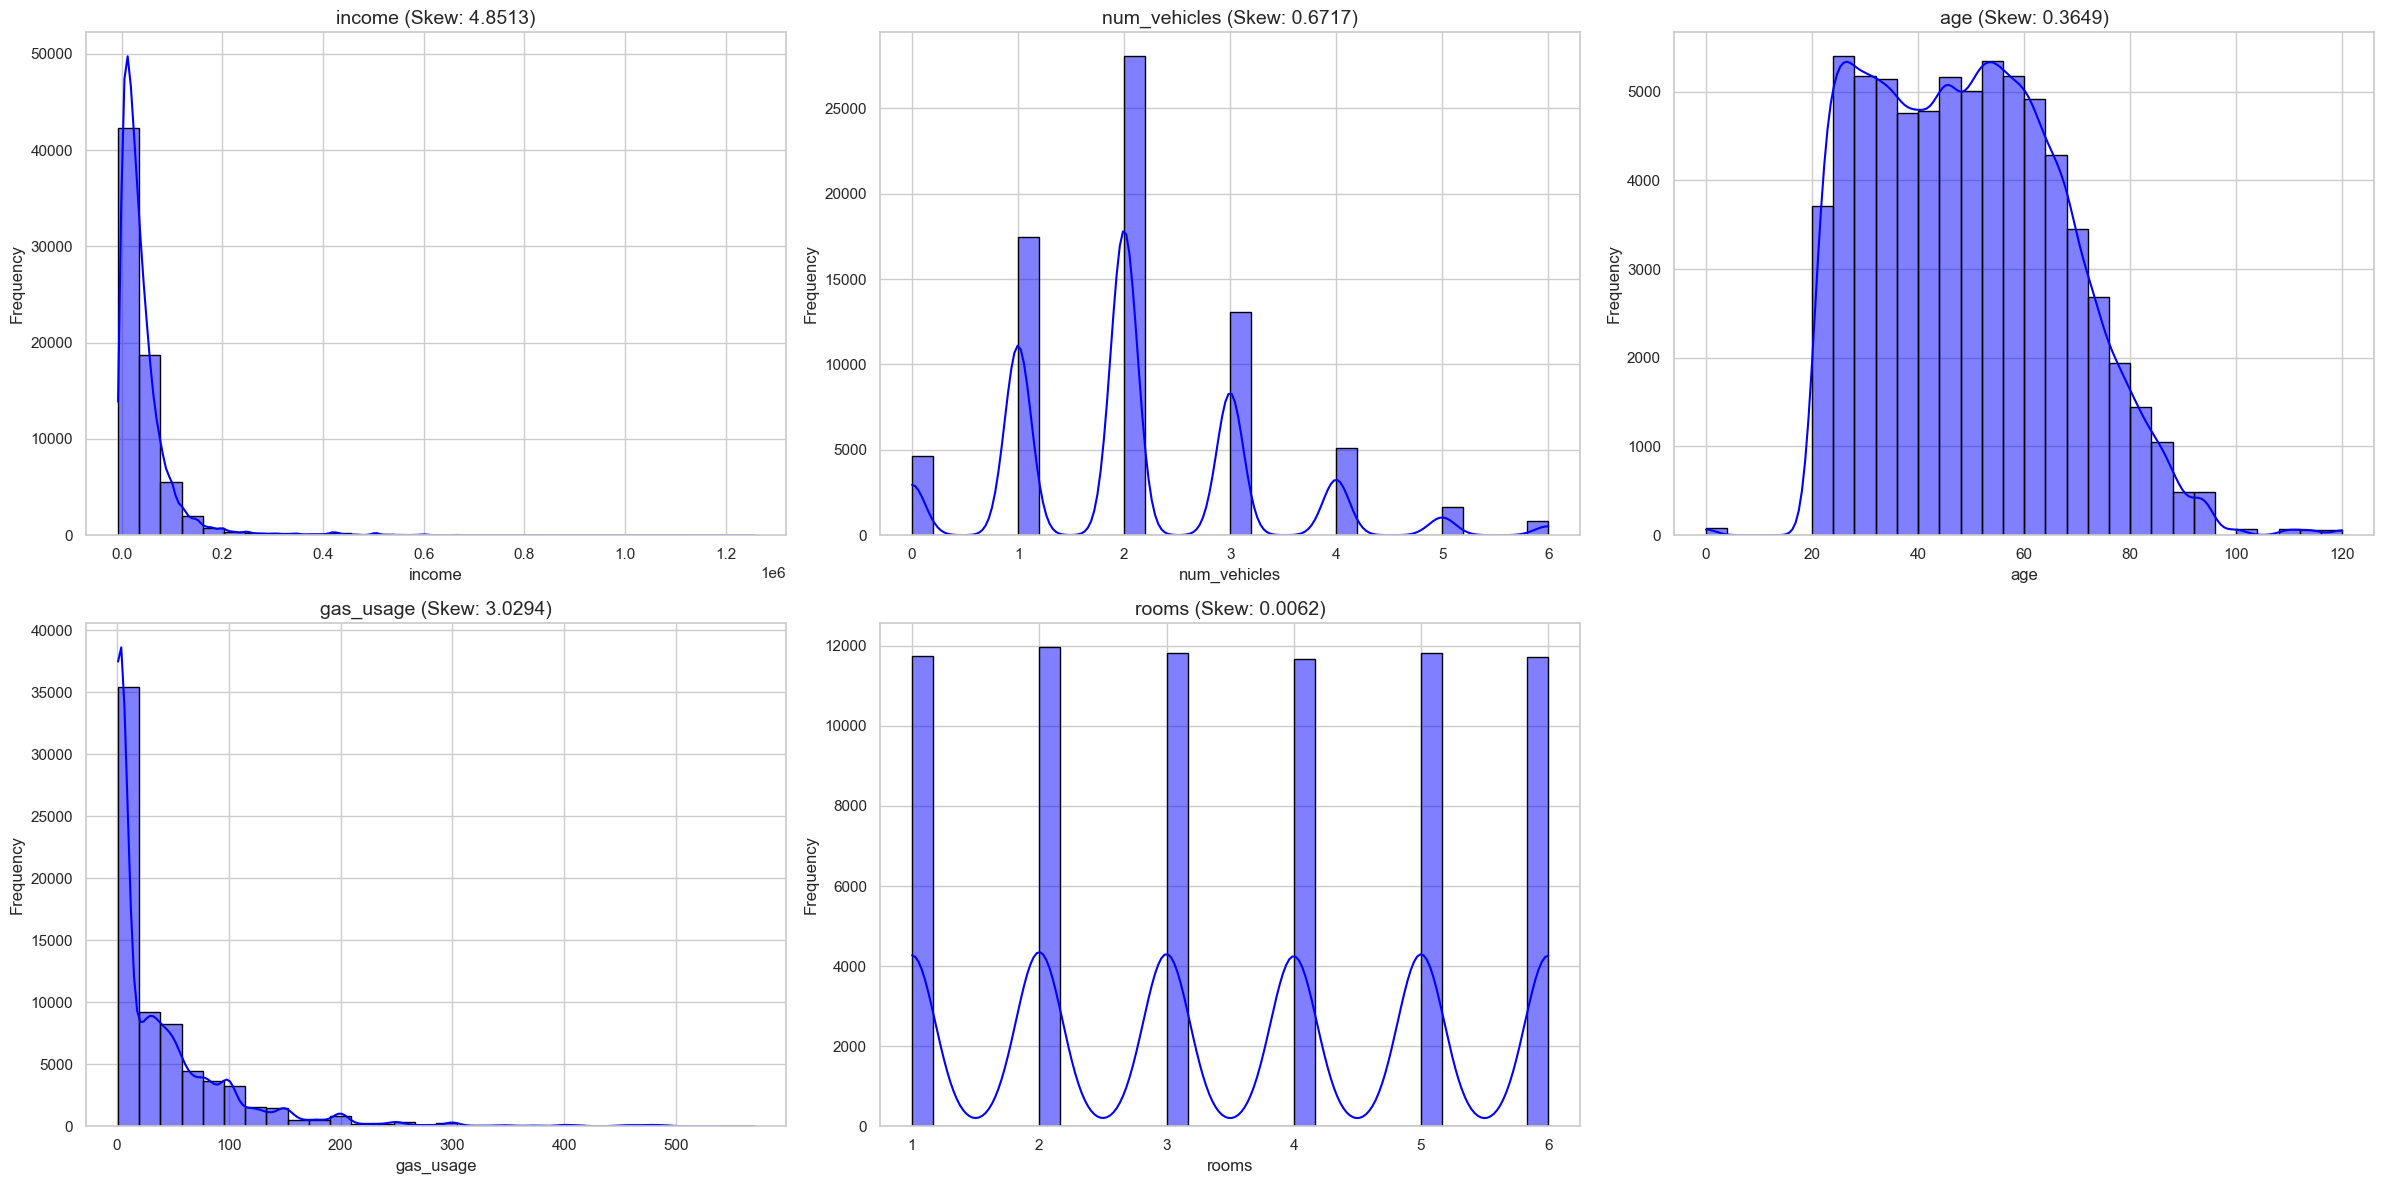

In [415]:
# Plot distribution of numerical features with skewness information
f, axes = plt.subplots(2, 3, figsize=(24, 12)) 
axes = axes.flatten()

# Loop through numerical features
for i, col in enumerate(df[numerical_features].columns):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color='blue', edgecolor='black')
    axes[i].set_title(f'{col} (Skew: {df[col].skew():.4f})', fontsize=14)
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)

# Hide any unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

##### Normal Probability Plots (Q-Q Plots)

These plots assess how well the data follows a normal distribution. Points deviating from the diagonal line indicate departures from normality, which may suggest outliers or the need for transformations.

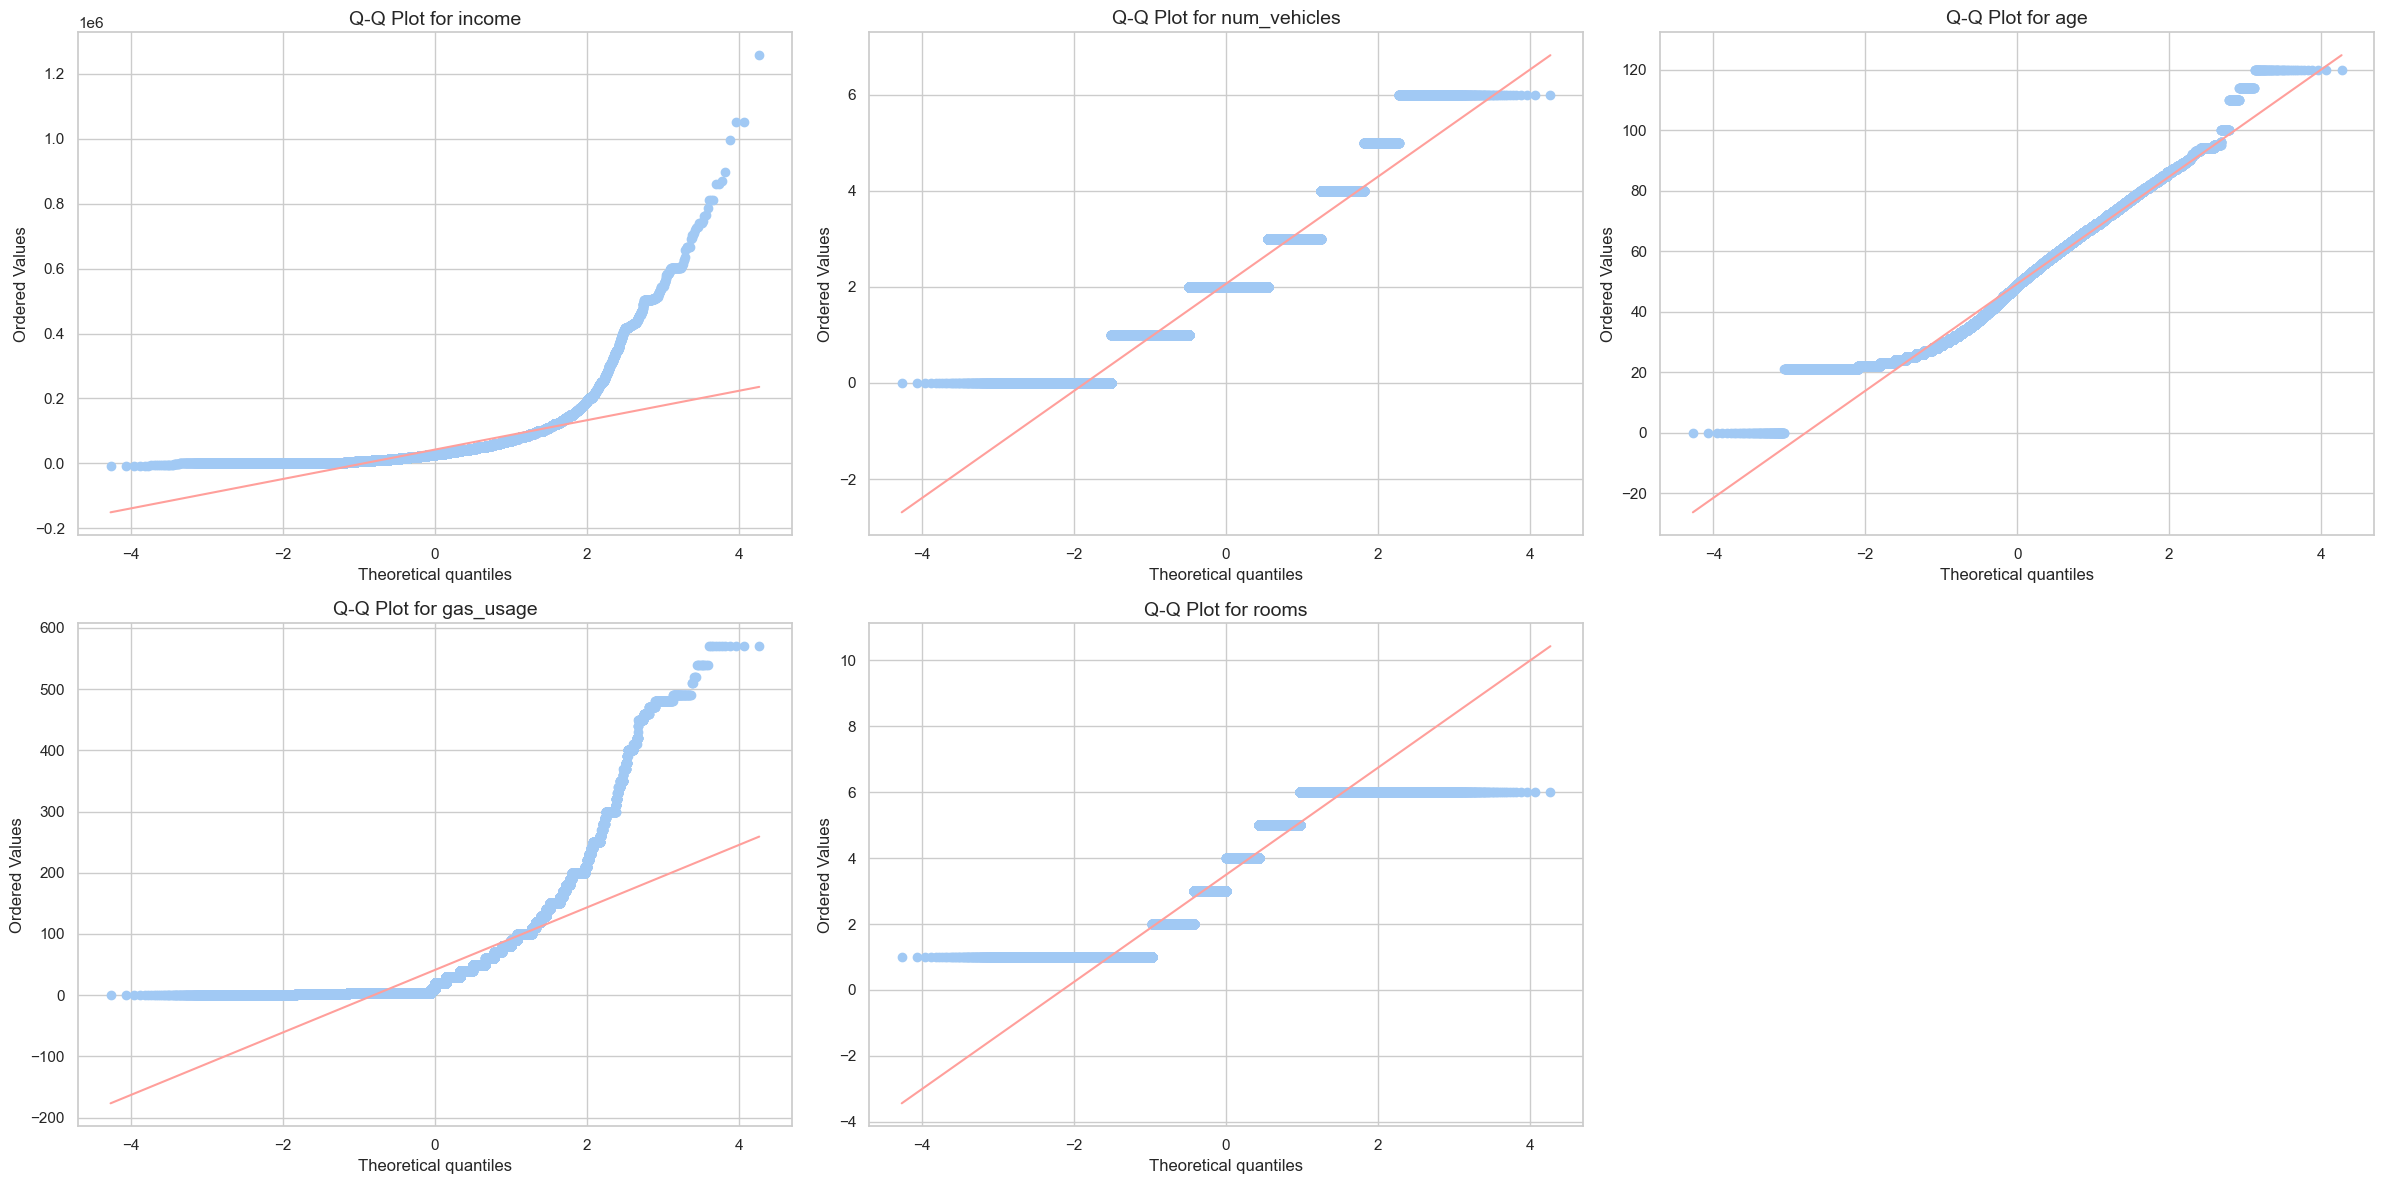

In [416]:
# Q-Q Plots for numerical features
f, axes = plt.subplots(2, 3, figsize=(24, 12)) 
axes = axes.flatten()

# Loop through numerical features
for i, col in enumerate(df[numerical_features].columns):
    stats.probplot(df[col], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {col}', fontsize=14)

# Hide any unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

##### Box Plots

Boxplots visually represent the spread of data and highlight potential outliers as points outside the whiskers.

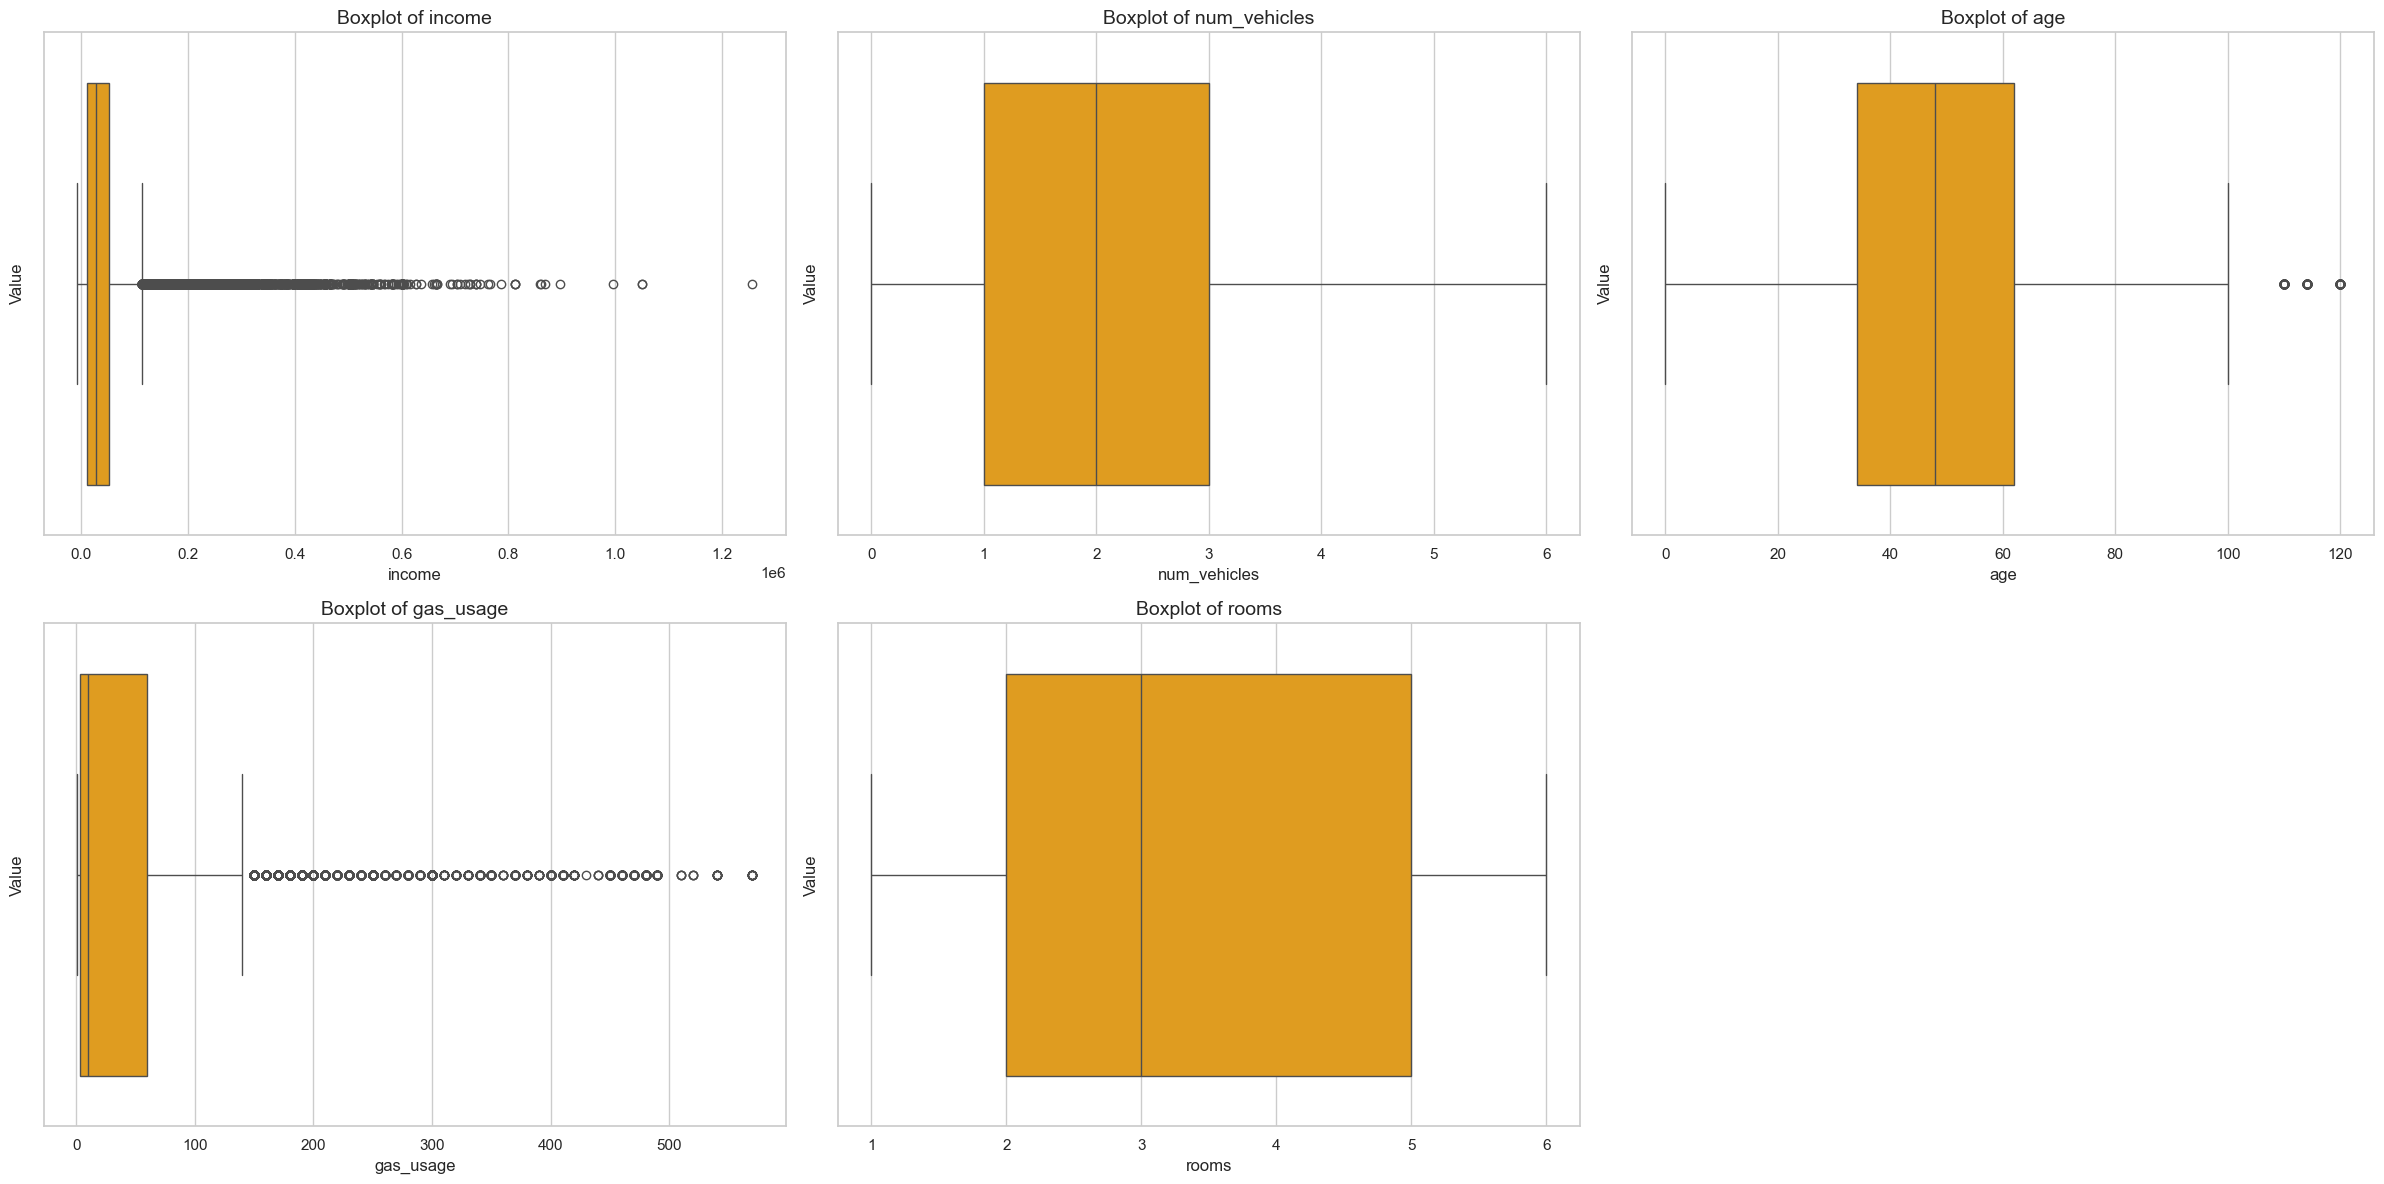

In [417]:
sns.set_theme(style="whitegrid", palette="pastel")

f, axes = plt.subplots(2, 3, figsize=(24, 12))  
axes = axes.flatten()

# Loop through numerical features and plot each
for i, feature in enumerate(numerical_features):
    sns.boxplot(x=df[feature], ax=axes[i], color='orange')
    axes[i].set_title(f'Boxplot of {feature}', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Value', fontsize=12)

# Hide unused subplots
for j in range(len(numerical_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


##### Scatter Plots

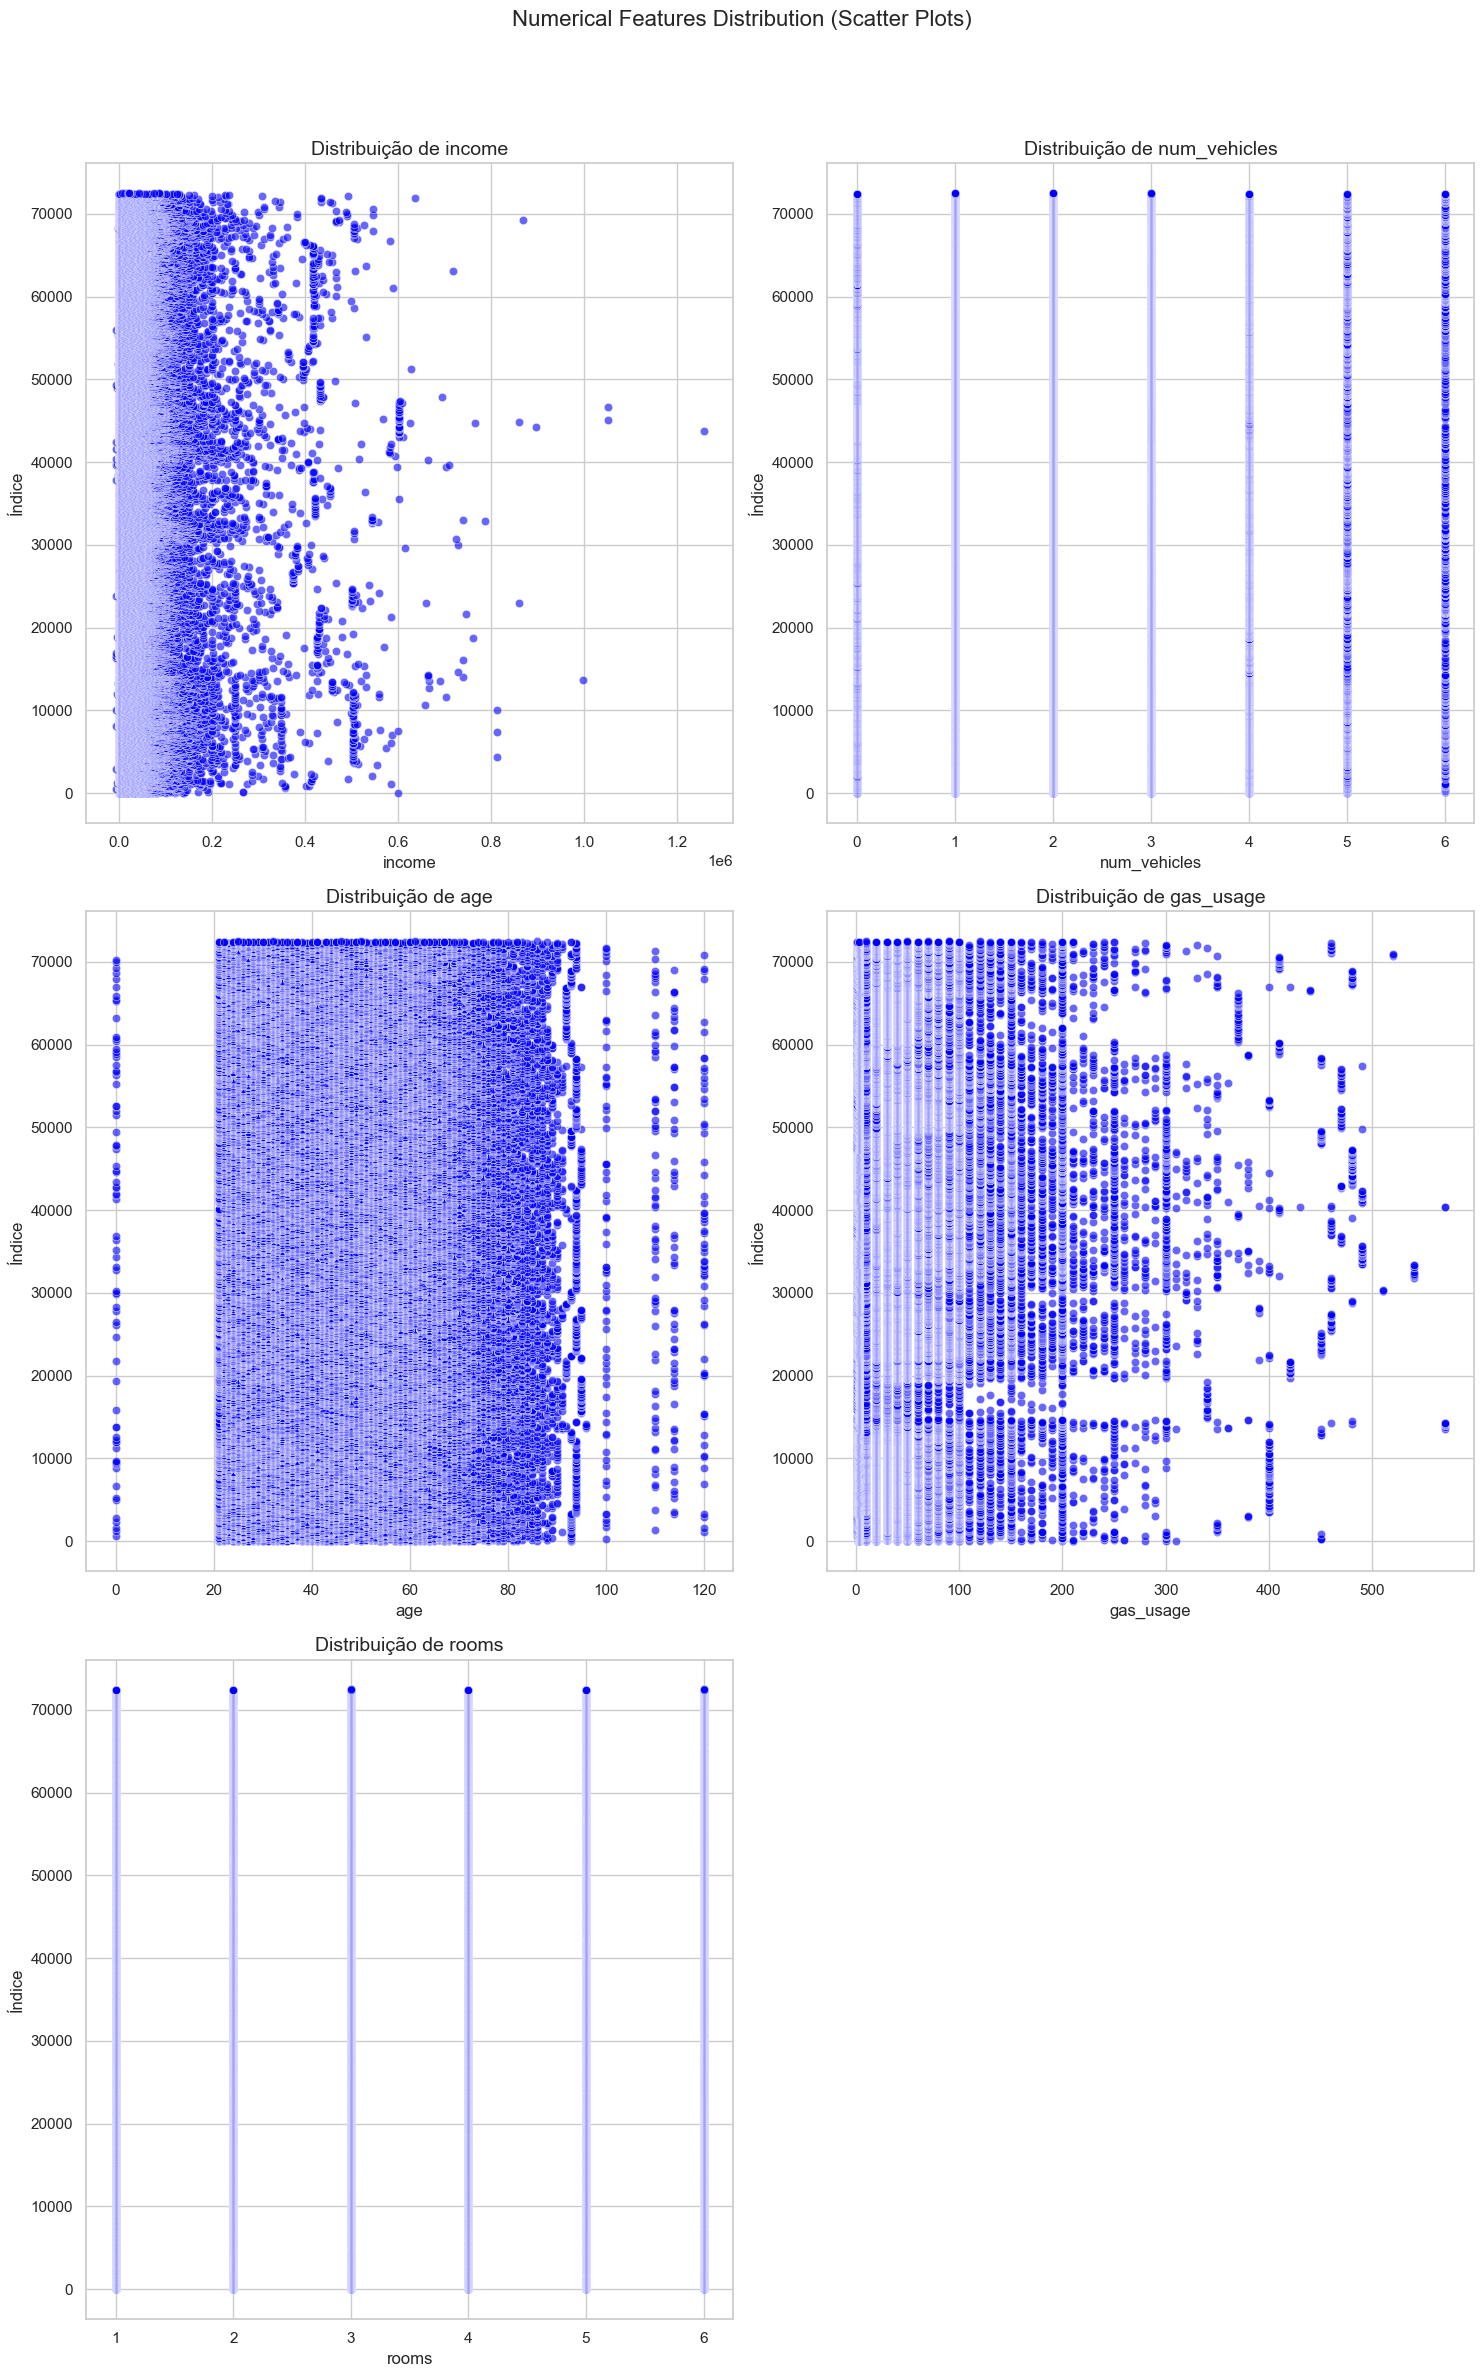

In [418]:
sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(15, 25))

# Create a scatter plot for each numerical feature
for i, feature in enumerate(numerical_features[:5], 1):
    plt.subplot(3, 2, i)  
    sns.scatterplot(data=df, x=feature, y=df.index, alpha=0.6, color='blue')  
    plt.title(f'Distribuição de {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Índice', fontsize=12)

plt.suptitle('Numerical Features Distribution (Scatter Plots)', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


#### Handling outliers in the income column

In [419]:
# Verify the presence of negative values in the 'income' column
negative_income = df['income'] < 0
print("Negative income values:", negative_income.sum())

Negative income values: 28


Although we have already removed 17 negative values when handling the NaNs in the `is_employed` column, 28 still remain.

In [420]:
# Drop rows with negative income
df = df[df['income'] >= 0]

In [421]:
# Count the number of income values less than 10000
low_income = df['income'] < 15000
print("Income values less than 10000:", low_income.sum())

Income values less than 10000: 21968


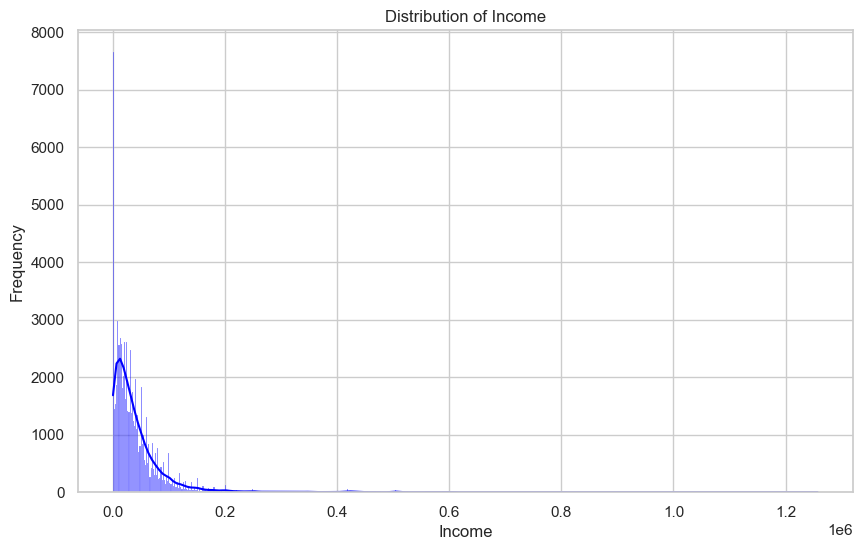

,income
count,7.072600e+04
mean,4.266208e+04
std,5.864869e+04
min,0.000000e+00
25%,1.130000e+04
50%,2.750000e+04
75%,5.210000e+04
max,1.257000e+06


In [422]:
# Check for the distribution of the income column to identify potential issues
plt.figure(figsize=(10, 6))
sns.histplot(df['income'], kde=True, color='blue')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

# Look at some of the extreme income values to spot any that appear to be monthly instead of annual
df[['income']].describe()

## Outliers que temos de tratar

- no **income** os valores são `X * 10^6` , logo podem haver pessoas que tenham metido o income mensal (?) ou pessoas que tenham metido o income anual (?) -> convém definirmos um valor (tipo: salário minimo/médio dos EUA * 12, e se o income for menor que isso, então multiplicamos por 12, pois é sinal que essa pessoa meteu o mensal...podemos é dar uma margem para partimes ou assim...)
- na **idade** creio que há imensas pessoas perto de 120 anos, isso é normal (?) , e algumas com zero anos (?) -> e no gráfico mais a baixo vemos pessoas com zero anos a receberem income, como vamos tratar disso (?)
- **nr de veiculos** parece ok, vemos que as colunas 1,2,3 e 4 são bem marcadas, mas 5 e 6 já começam a ficar menos carregadas
- **uso do gas** parece que temos ali uns outliers à direita.. se calhar convém verificarmos se eles se relacionam com a casa ser grande / ter muitos quartos / têm muitaos carros... se isso se verificar é porque têm boa vida financeira, se não se verificar são outliers...
- o **nr de quartos** parece me tudo bem

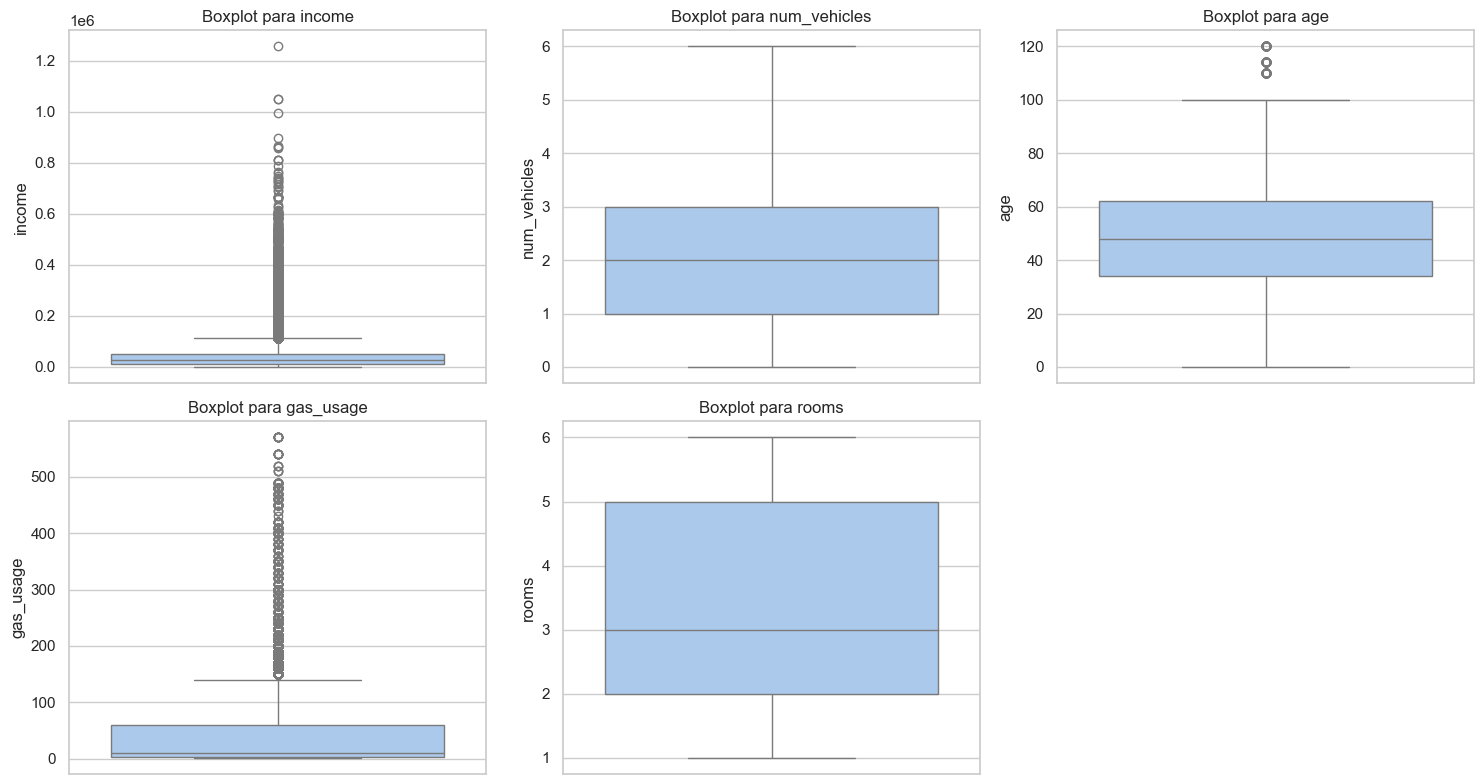

In [423]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot para {col}')
plt.tight_layout()
plt.show()

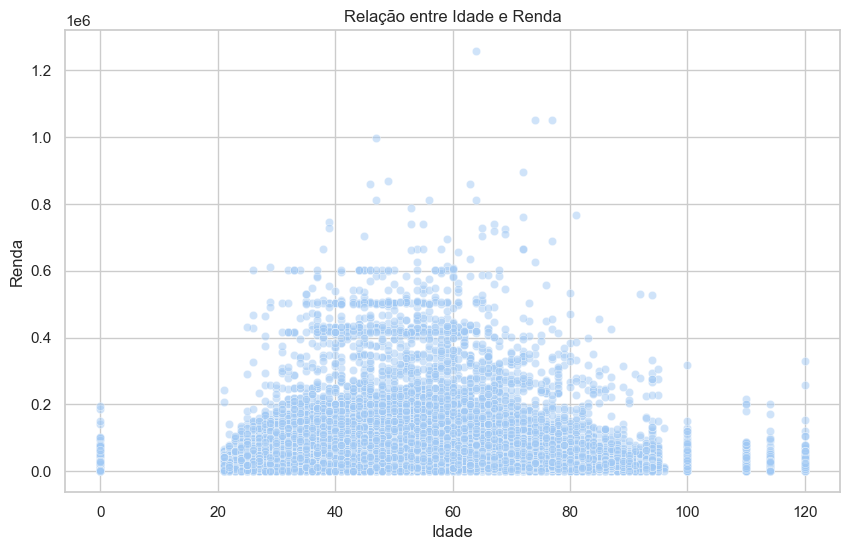

In [424]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='income', alpha=0.5)
plt.title('Relação entre Idade e Renda')
plt.xlabel('Idade')
plt.ylabel('Renda')
plt.show()

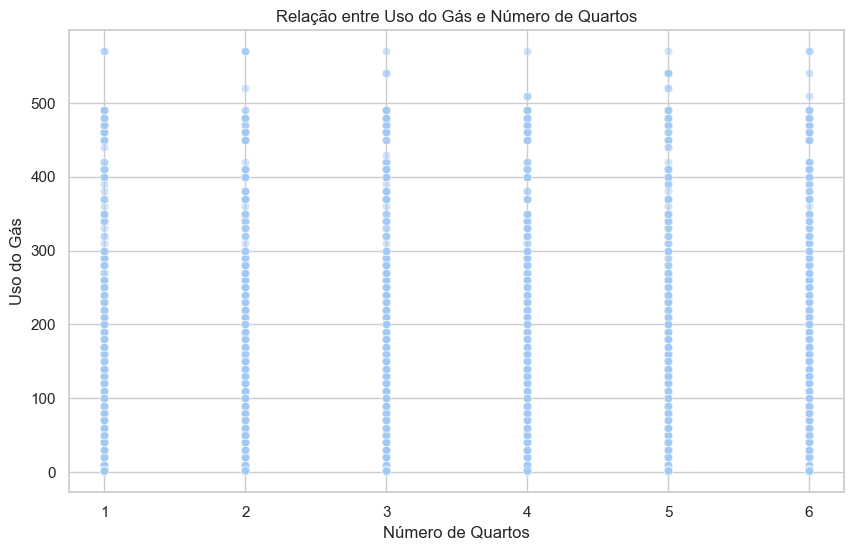

In [425]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='rooms', y='gas_usage', alpha=0.5)
plt.title('Relação entre Uso do Gás e Número de Quartos')
plt.xlabel('Número de Quartos')
plt.ylabel('Uso do Gás')
plt.show()

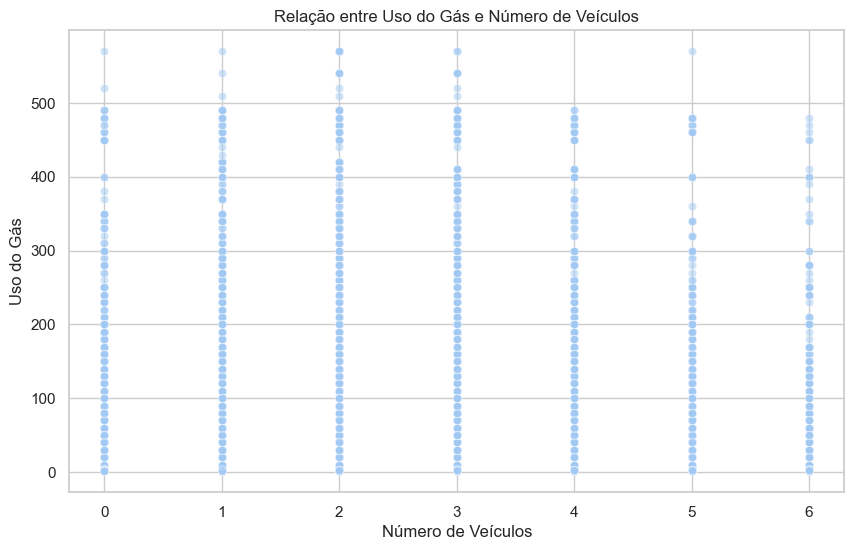

In [426]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_vehicles', y='gas_usage', alpha=0.5)
plt.title('Relação entre Uso do Gás e Número de Veículos')
plt.xlabel('Número de Veículos')
plt.ylabel('Uso do Gás')
plt.show()

# Outliers in gas_usage

In [427]:
Q1 = df['gas_usage'].quantile(0.25)
Q3 = df['gas_usage'].quantile(0.75)
IQR = Q3 - Q1

# Define limits for outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Count the outliers
outliers = df[(df['gas_usage'] < lower_limit) | (df['gas_usage'] > upper_limit)]
outlier_count = outliers.shape[0]

print(f"Number of outliers: {outlier_count}")


Number of outliers: 4592


We noticed that there is a significant amount of outliers in this variable. Therefore, we should not simply remove them. However, by analyzing the boxplot of this variable, we observed that the outliers are most likely annual values. Thus, a good approach would be to divide these values by 12, so that all values are within the same unit of measure.


# AQUI TEMOS DE ESCOLHER

## Se dividirmos por 12 de forma a ficarem todos mensais

In [428]:
df.loc[df['gas_usage'] > upper_limit, 'gas_usage'] /= 12

## Se tratassemos dos outliers do gas_usage com um log

In [429]:
#df['gas_usage'] = np.log1p(df['gas_usage'])

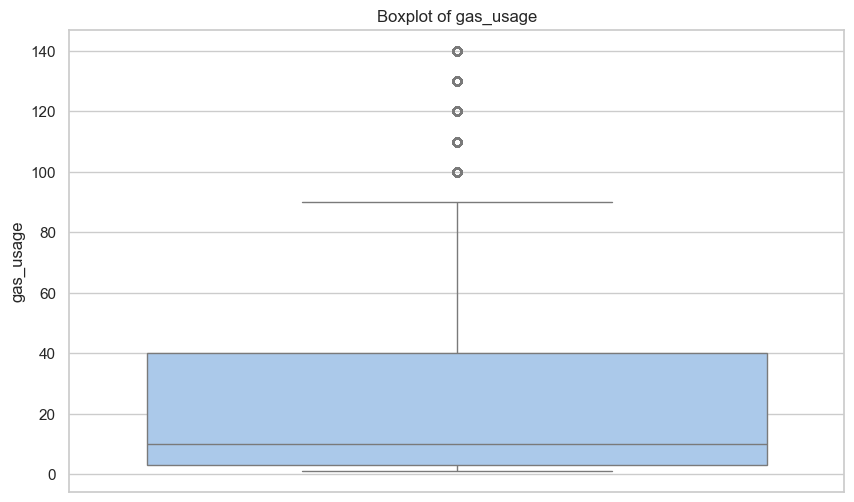

In [430]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='gas_usage')
plt.title('Boxplot of gas_usage')
plt.ylabel('gas_usage')
plt.show()

# Outliers in age

In [431]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

upper_limit = Q3 + 1.5 * IQR

print(f"Upper limit: {upper_limit}")

age_outliers = df[df['age'] > upper_limit]
age_outliers_count = age_outliers.shape[0]
print(f"Number of outliers: {age_outliers_count}")

Upper limit: 104.0
Number of outliers: 186


Since there are only 186 values, which is less than 0.5% of the dataset, we will remove these values.

In [432]:
df = df[df['age'] <= upper_limit]

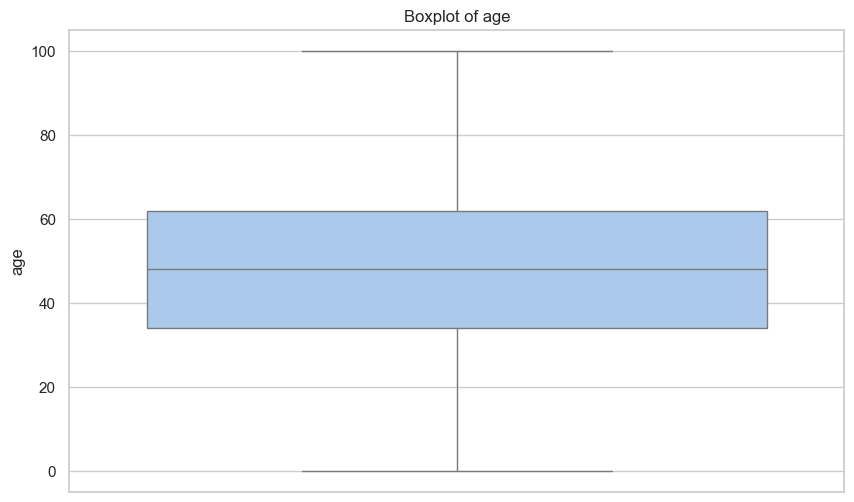

In [433]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, y='age')
plt.title('Boxplot of age')
plt.ylabel('age')
plt.show()

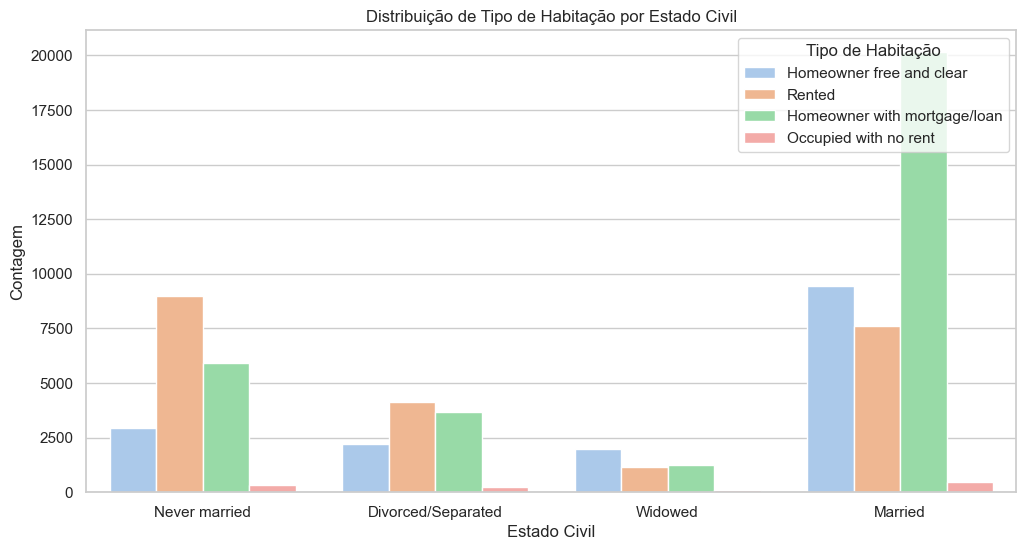

In [434]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='marital_status', hue='housing_type')
plt.title('Distribuição de Tipo de Habitação por Estado Civil')
plt.xlabel('Estado Civil')
plt.ylabel('Contagem')
plt.legend(title='Tipo de Habitação', loc='upper right')
plt.show()

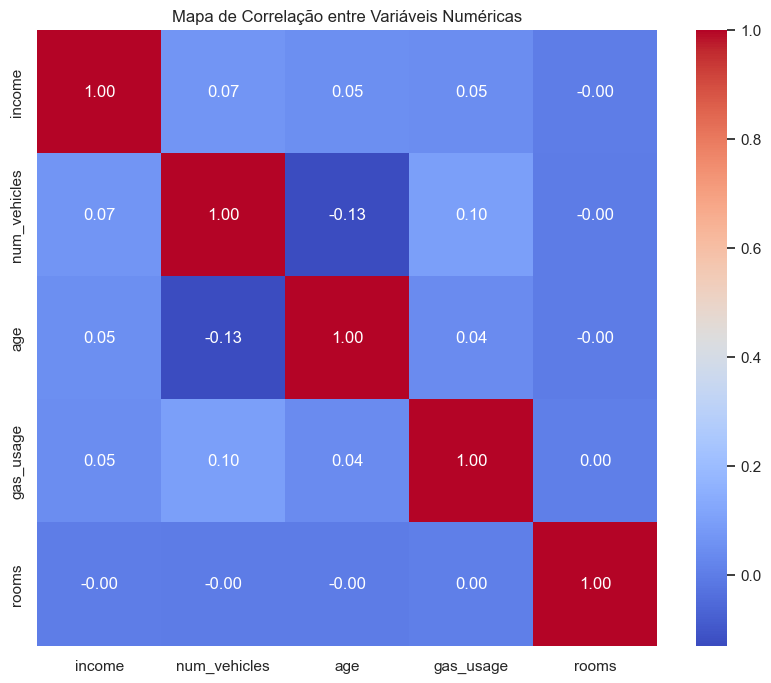

In [435]:
numeric_columns = df.select_dtypes(include=[np.number])
correlation = numeric_columns.corr()

# correlação entre variáveis numéricas
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação entre Variáveis Numéricas')
plt.show()


/var/folders/vl/y_41x5_50d55msx55mh9_lk00000gn/T/ipykernel_90014/2988973052.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='housing_type', y='income', ci=None)


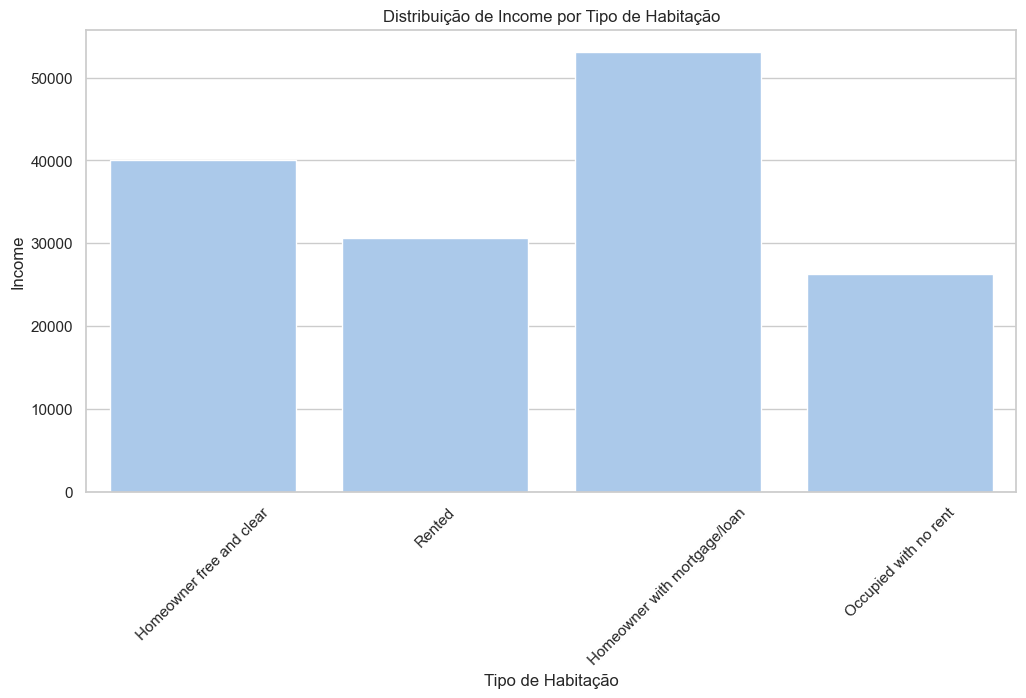

In [436]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='housing_type', y='income', ci=None)
plt.title('Distribuição de Income por Tipo de Habitação')
plt.xlabel('Tipo de Habitação')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.show()

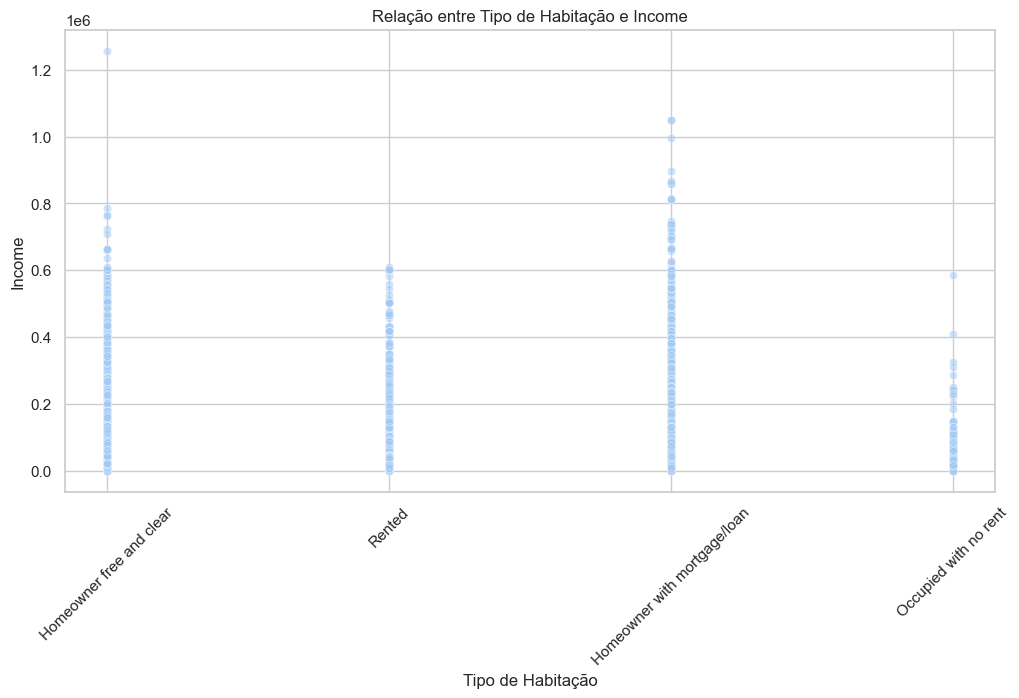

In [437]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='housing_type', y='income', alpha=0.5)
plt.title('Relação entre Tipo de Habitação e Income')
plt.xlabel('Tipo de Habitação')
plt.ylabel('Income')
plt.xticks(rotation=45)
plt.show()

# começar a preparar os modelos

#### começamos com um problema, que há uma grande disparidade entre o numero de true e o numero de falses

In [438]:
print(df['health_ins'].value_counts())

health_ins
True     64135
False     6405
Name: count, dtype: int64


In [439]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# passar colunas boolean para strings
for column in df.select_dtypes(include=['bool']).columns:
    df[column] = df[column].astype(str)

# verificar se ta tudo em strings
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str)

# encoding
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# separar as features e a variável alvo
X = df.drop(columns=['health_ins'])
y = df['health_ins']

# dividir os dados em treino e teste (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
print(f'K-Nearest Neighbors Accuracy: {accuracy_knn:.2f}')
print(f'K-Nearest Neighbors F1 Score: {f1_knn:.2f}')

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')
print(f'Decision Tree F1 Score: {f1_dt:.2f}')

svc = SVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc) 
print(f'Support Vector Machine Accuracy: {accuracy_svc:.2f}')
print(f'Support Vector Machine F1 Score: {f1_svc:.2f}')

K-Nearest Neighbors Accuracy: 0.90
K-Nearest Neighbors F1 Score: 0.95
Decision Tree Accuracy: 0.84
Decision Tree F1 Score: 0.91
Support Vector Machine Accuracy: 0.91
Support Vector Machine F1 Score: 0.95


# tentar corrigir a diferença entre true / falses 

### com smote

In [440]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# ver como ficaram as classes
print("Distribuição das classes após SMOTE:")
print(y_resampled.value_counts()) 


Distribuição das classes após SMOTE:
health_ins
1    51345
0    51345
Name: count, dtype: int64


# aplicar novamente os modelos

In [ ]:
knn.fit(X_resampled, y_resampled)
y_pred_knn_resampled = knn.predict(X_test)
accuracy_knn_resampled = accuracy_score(y_test, y_pred_knn_resampled)
f1_knn_resampled = f1_score(y_test, y_pred_knn_resampled)
print(f'K-Nearest Neighbors Accuracy (Resampled): {accuracy_knn_resampled:.2f}')
print(f'K-Nearest Neighbors F1 Score (Resampled): {f1_knn_resampled:.2f}')

dt.fit(X_resampled, y_resampled)
y_pred_dt_resampled = dt.predict(X_test)
accuracy_dt_resampled = accuracy_score(y_test, y_pred_dt_resampled)
f1_dt_resampled = f1_score(y_test, y_pred_dt_resampled)
print(f'Decision Tree Accuracy (Resampled): {accuracy_dt_resampled:.2f}')
print(f'Decision Tree F1 Score (Resampled): {f1_dt_resampled:.2f}')

svc.fit(X_resampled, y_resampled)
y_pred_svc_resampled = svc.predict(X_test)
accuracy_svc_resampled = accuracy_score(y_test, y_pred_svc_resampled)
f1_svc_resampled = f1_score(y_test, y_pred_svc_resampled)
print(f'Support Vector Machine Accuracy (Resampled): {accuracy_svc_resampled:.2f}')
print(f'Support Vector Machine F1 Score (Resampled): {f1_svc_resampled:.2f}')

K-Nearest Neighbors Accuracy (Resampled): 0.73
K-Nearest Neighbors F1 Score (Resampled): 0.83
Decision Tree Accuracy (Resampled): 0.82
Decision Tree F1 Score (Resampled): 0.90


### com undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print("Distribuição após Under-sampling:")
print(y_resampled.value_counts())


Distribuição após Under-sampling:
health_ins
0    5140
1    5140
Name: count, dtype: int64


In [ ]:
knn.fit(X_resampled, y_resampled)
y_pred_knn_resampled = knn.predict(X_test)
accuracy_knn_resampled = accuracy_score(y_test, y_pred_knn_resampled)
f1_knn_resampled = f1_score(y_test, y_pred_knn_resampled)
print(f'K-Nearest Neighbors Accuracy (Resampled): {accuracy_knn_resampled:.2f}')
print(f'K-Nearest Neighbors F1 Score (Resampled): {f1_knn_resampled:.2f}')

dt.fit(X_resampled, y_resampled)
y_pred_dt_resampled = dt.predict(X_test)
accuracy_dt_resampled = accuracy_score(y_test, y_pred_dt_resampled)
f1_dt_resampled = f1_score(y_test, y_pred_dt_resampled)
print(f'Decision Tree Accuracy (Resampled): {accuracy_dt_resampled:.2f}')
print(f'Decision Tree F1 Score (Resampled): {f1_dt_resampled:.2f}')

svc.fit(X_resampled, y_resampled)
y_pred_svc_resampled = svc.predict(X_test)
accuracy_svc_resampled = accuracy_score(y_test, y_pred_svc_resampled)
f1_svc_resampled = f1_score(y_test, y_pred_svc_resampled)
print(f'Support Vector Machine Accuracy (Resampled): {accuracy_svc_resampled:.2f}')
print(f'Support Vector Machine F1 Score (Resampled): {f1_svc_resampled:.2f}')

K-Nearest Neighbors Accuracy (Resampled): 0.62
K-Nearest Neighbors F1 Score (Resampled): 0.74
Decision Tree Accuracy (Resampled): 0.65
Decision Tree F1 Score (Resampled): 0.77
Support Vector Machine Accuracy (Resampled): 0.53
Support Vector Machine F1 Score (Resampled): 0.66


### com oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Distribuição após Over-sampling:")
print(y_resampled.value_counts())


Distribuição após Over-sampling:
health_ins
1    51440
0    51440
Name: count, dtype: int64


In [ ]:
knn.fit(X_resampled, y_resampled)
y_pred_knn_resampled = knn.predict(X_test)
accuracy_knn_resampled = accuracy_score(y_test, y_pred_knn_resampled)
f1_knn_resampled = f1_score(y_test, y_pred_knn_resampled)
print(f'K-Nearest Neighbors Accuracy (Resampled): {accuracy_knn_resampled:.2f}')
print(f'K-Nearest Neighbors F1 Score (Resampled): {f1_knn_resampled:.2f}')

dt.fit(X_resampled, y_resampled)
y_pred_dt_resampled = dt.predict(X_test)
accuracy_dt_resampled = accuracy_score(y_test, y_pred_dt_resampled)
f1_dt_resampled = f1_score(y_test, y_pred_dt_resampled)
print(f'Decision Tree Accuracy (Resampled): {accuracy_dt_resampled:.2f}')
print(f'Decision Tree F1 Score (Resampled): {f1_dt_resampled:.2f}')

svc.fit(X_resampled, y_resampled)
y_pred_svc_resampled = svc.predict(X_test)
accuracy_svc_resampled = accuracy_score(y_test, y_pred_svc_resampled)
f1_svc_resampled = f1_score(y_test, y_pred_svc_resampled)
print(f'Support Vector Machine Accuracy (Resampled): {accuracy_svc_resampled:.2f}')
print(f'Support Vector Machine F1 Score (Resampled): {f1_svc_resampled:.2f}')

K-Nearest Neighbors Accuracy (Resampled): 0.76
K-Nearest Neighbors F1 Score (Resampled): 0.86
Decision Tree Accuracy (Resampled): 0.85
Decision Tree F1 Score (Resampled): 0.92
Support Vector Machine Accuracy (Resampled): 0.50
Support Vector Machine F1 Score (Resampled): 0.63
